===================================================  
 Natural Language Processing: Twitter Sentiment Analysis for Jakarta Gubernatorial Election 2017

by __Angger Rizky Firdaus__  
This project is developed to accomplish Graded Challenge 7 of the FTDS Hacktiv8 program.  
Creating a natural language processing to predict sentiment analysis.

===================================================


Link Interface [Huggingface](https://huggingface.co/spaces/batraccoon/Indonesian-Sentiment-Analysis-App)

__Objective__

During every political season, social media platforms are flooded with various narratives expressed by the public. These narratives can be positive or negative. To understand the sentiment of the public towards a particular post, we will develop a Natural Language Processing (NLP) model. This model aims to analyze the sentiments of users based on their posts on social media platforms. The model will be trained using the Twitter sentiment dataset from the 2017 Jakarta Gubernatorial Election, available on [GitHub](https://rizalespe.github.io/Dataset-Sentimen-Analisis-Bahasa-Indonesia/).

# Library

In [2]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score,confusion_matrix
import re
import string
import tensorflow as tf
import tensorflow_hub as tf_hub
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization,Embedding, Concatenate, Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
import pickle

#  Data Loading

In [3]:
#load dataset
dataset = pd.read_csv('dataset_tweet_sentiment_pilkada_DKI_2017.csv')
dataset

,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...
...,...,...,...,...
895,896,positive,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ..."
896,897,positive,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...
897,898,positive,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...
898,899,positive,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...


Loading the dataset has been successful.

In [4]:
#assign a new variable to display the dataset
df = dataset.copy()

In [5]:
#summary dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              900 non-null    int64 
 1   Sentiment       900 non-null    object
 2   Pasangan Calon  900 non-null    object
 3   Text Tweet      900 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.3+ KB


Based on df.info(), the 2017 regional election Twitter sentiment dataset has 900 rows with 4 columns. There is no missing data (missing value) and the datatype is also appropriate.

In [6]:
#checking missing values
df.isnull().any()


Id                False
Sentiment         False
Pasangan Calon    False
Text Tweet        False
dtype: bool

there are no missing values.

In [7]:
#checking duplicated data
df.duplicated().any()

False

no duplicate data.

In [8]:
#syntax to see the unique values of the Sentiment column
df['Sentiment'].unique()

array(['negative', 'positive'], dtype=object)

The sentiment column has 2 unique values, namely negative and positive, which explains the sentiment contained in the Text Tweet column.

# Exploratory Data Analysis

In [9]:
#assign variable untuk menampilkan dataset 
eda = dataset.copy()

## Comparison of the Number of Tweets for Each Candidate Pair

Text(0, 0.5, '')

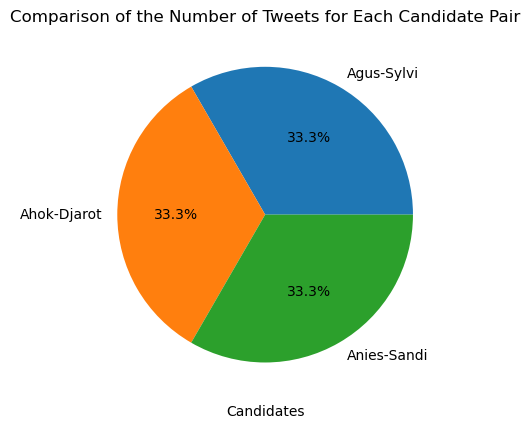

In [10]:
#display pie chart
df['Pasangan Calon'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Comparison of the Number of Tweets for Each Candidate Pair')
plt.xlabel('Candidates')
plt.ylabel('')

This dataset exhibits a balanced distribution of tweets for each candidate pair, with approximately 33.3% for both the Ahok-Djarot, Agus-Sylvi, and Anies-Sandi pairs.

## Comparison of Number of Tweet Sentiments

Text(0, 0.5, '..')

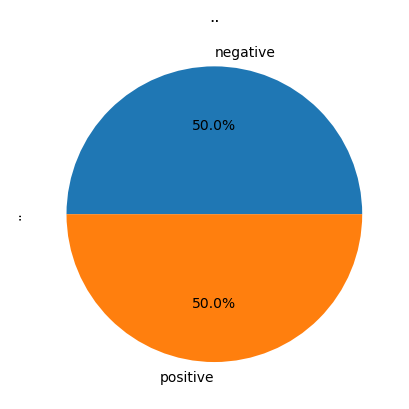

In [ ]:
#display pie chart
df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('..')
plt.ylabel('..')

This dataset presents a balanced distribution between positive and negative sentiments, with 50% for each. A balanced dataset is beneficial for the training process as it allows the model to learn from the data effectively.

## Wordcloud to Display the Most Frequently Appearing Words in the Dataset

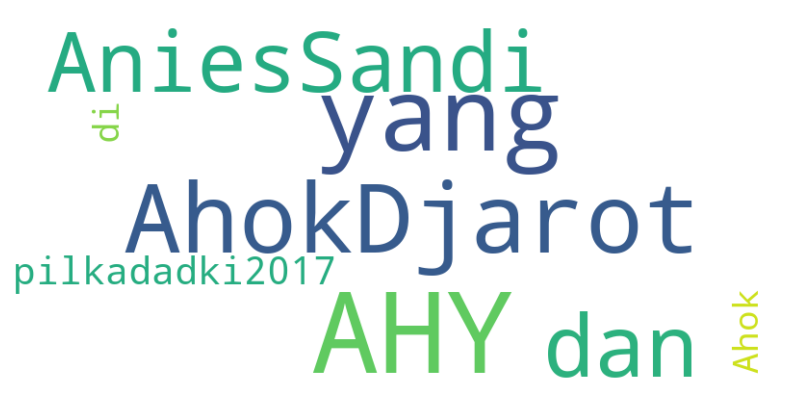

In [ ]:
# Combines all tweet text into one string
all_tweets_text = ' '.join(eda['Text Tweet'])  

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10, max_words=8).generate(all_tweets_text) 

# Displays WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Based on the wordcloud visualization above, here are the 8 words that appear most frequently in tweets in this dataset such as pilkadadki 2017, yang, AHY, AniesSandi, and, di, AhokDjarot, and Ahok.

# Feature Engineering

## Preprocessing

The feature engineering process in NLP models is different from usual machine learning models. The process carried out is _preprocessing_ the data so that the model can learn the writing.

The _Text Preprocessing_ process is like:
- remove numbers, hashtags, urls, usernames, whitespace, symbols
- handling stop words
- stemming and lemmitization

stopword uses a list prepared in the 2017 regional election tweet sentiment github repository [github](https://github.com/rizalespe/Dataset-Sentimen-Analysis-Bahasa-Indonesia/blob/master/stopword_tweet_pilkada_DKI_2017.csv).

In [ ]:
#syntax for stopword
stw = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/stopword_tweet_pilkada_DKI_2017.csv')
stpwds_id = stw.values.tolist()
stpwds_id.append(['ada'])

# syntax for stemmer
stemmer = StemmerFactory().create_stemmer()

In [ ]:
# making function for text preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [ ]:
#perform text processing in the Tweet Text column
df['text_processed'] = df['Text Tweet'].apply(lambda x: text_preprocessing(x))
df

,Id,Sentiment,Pasangan Calon,Text Tweet,text_processed
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning olah dukung mulai serang p...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara apa kasihan yaa lap itu air mata wkwkwkwk
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau aku sih gak nunggu hasil akhir qc tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...,kasi oh kasi dengan peluru milyar untuk tiap r...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya dukung hayo dukung putar
...,...,...,...,...,...
895,896,positive,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali saja bpk lihat lagi di rspun tetap selfie...
896,897,positive,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...,kita harus dapat rangkul semua orang tanpa bat...
897,898,positive,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...,ini jago bidang digital smiling face with sung...
898,899,positive,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...,


Text processing has been done

In [ ]:
#encode positive and negative sentiments into numbers
df['Sentiment'] = df['Sentiment'].replace({'negative' : 0, 'positive' : 1})
df

,Id,Sentiment,Pasangan Calon,Text Tweet,text_processed
0,1,0,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning olah dukung mulai serang p...
1,2,0,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara apa kasihan yaa lap itu air mata wkwkwkwk
2,3,0,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau aku sih gak nunggu hasil akhir qc tp lag...
3,4,0,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...,kasi oh kasi dengan peluru milyar untuk tiap r...
4,5,0,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya dukung hayo dukung putar
...,...,...,...,...,...
895,896,1,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali saja bpk lihat lagi di rspun tetap selfie...
896,897,1,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...,kita harus dapat rangkul semua orang tanpa bat...
897,898,1,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...,ini jago bidang digital smiling face with sung...
898,899,1,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...,


In [ ]:
#feature selection
#drop columns that are not used, namely ID, Tweet Text, and Candidate Pair
df.drop(['Id','Text Tweet','Pasangan Calon'],axis=1,inplace=True)
df

,Sentiment,text_processed
0,0,banyak akun kloning olah dukung mulai serang p...
1,0,bicara apa kasihan yaa lap itu air mata wkwkwkwk
2,0,kalau aku sih gak nunggu hasil akhir qc tp lag...
3,0,kasi oh kasi dengan peluru milyar untuk tiap r...
4,0,maaf ya dukung hayo dukung putar
...,...,...
895,1,kali saja bpk lihat lagi di rspun tetap selfie...
896,1,kita harus dapat rangkul semua orang tanpa bat...
897,1,ini jago bidang digital smiling face with sung...
898,1,


The dataset has been preprocessed and unused columns have been dropped.

## Split X dan Y train, test, dan validation

In [ ]:
#Split data menjadi X/y train, X/y test,dan X/y validation
X_train_val, X_test, y_train_val, y_test = train_test_split(df['text_processed'],df['Sentiment'],
                                        test_size=0.11,
                                        random_state=20,
                                        stratify=df['Sentiment'])

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                        y_train_val,
                                        test_size=0.05,
                                        random_state=20,
                                        stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (760,)
Val Size   :  (41,)
Test Size  :  (99,)


In [ ]:
#menghitung perbandingan sentimen pada kolom target
y_train.value_counts(),

(Sentiment
 1    380
 0    380
 Name: count, dtype: int64,)

The data after splitting is still balanced so that further processing can be carried out

# Artificial Neural Network

This NLP model will be implemented using the Sequential API with two approaches:
1. NLP model with a single layer
2. NLP model with multiple layers

The model that demonstrates superior performance will be selected for deployment.

In [ ]:
# Get Vocabularies dengan CountVocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<760x2130 sparse matrix of type '<class 'numpy.int64'>'
	with 8307 stored elements in Compressed Sparse Row format>

__Explanation of CountVectorizer Results__

760: This is the number of texts being processed. For instance, if the dataset contains 760 tweets, each row in this matrix will represent one article or one tweet.

2130: This is the number of unique words or tokens found across all documents. Each column in this matrix represents one word or token.

8307: This is the count of occurrences of the recorded words across all documents. It means these words appear repeatedly in the texts being processed. This number reflects how often these words occur in the corpus of analyzed texts.

In [ ]:
#calculate the total vocab and maximum sentence length in the dataset
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  2130
Maximum Sentence Length :  46 tokens


As explained above, there are 2130 unique words or vocab in the dataset with the maximum sentence being 46 words or 46 tokens.

In [ ]:
#assign TextVectorization to make text into tokens
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [ ]:
#assign Embedding to make text into numbers
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [ ]:
#assign callback to speed up computing and reduce learning rate
callbacks= [
 EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0,
    restore_best_weights=True),
    ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.01,
    patience=2)
]

Callbacks will be used during fitting to speed up computation when the model learning process does not experience significant improvements.

## NLP with Single Layer

In this model, 1 layer with 10 neurons will be used using the GRU (Gated Recurrent Unit) algorithm.

In [ ]:
#Model Definition

## Clear Session
seed = 100
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add((GRU(10, return_sequences=False, kernel_initializer=tf.keras.initializers.HeNormal(seed))))
model_lstm_1.add(Dense(1, activation='sigmoid'))

model_lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 46)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 46, 128)           272640    
                                                                 
 gru (GRU)                   (None, 10)                4200      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 276851 (1.06 MB)
Trainable params: 276851 (1.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In the summary of the model, the input will undergo _TextVectorization_ and _Embedding_ processes before entering the hidden layer with the GRU algorithm. After passing through the hidden layer, go straight to the output which produces output 1.

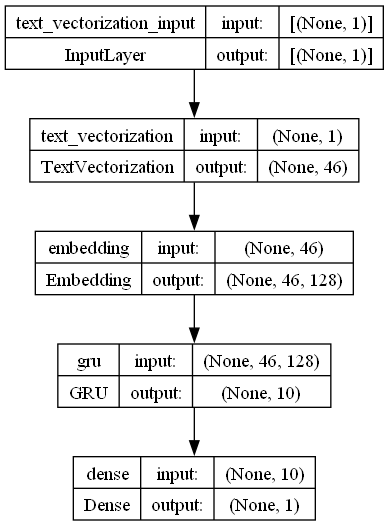

In [ ]:
#Visualization of model
tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

Visualization of the model process is performed. The model runs sequentially.

In [ ]:
# training process (fit)
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val),callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 2s 32ms/step - loss: 0.6939 - accuracy: 0.4987 - val_loss: 0.6929 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.6935 - accuracy: 0.4697 - val_loss: 0.6930 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 4/30
24/24 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.5013 - val_loss: 0.6930 - val_accuracy: 0.5122 - lr: 1.0000e-05
Epoch 5/30
24/24 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5013 - val_loss: 0.6930 - val_accuracy: 0.5122 - lr: 1.0000e-05
Epoch 6/30
24/24 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5013 - val_loss: 0.6930 - val_accuracy: 0.5122 - lr: 1.0000e-07


The model has an accuracy of 50.13% with a loss of 69.30% on the training data and an accuracy of 51.22% with a loss of 69.29% on the validation data. Looking at the training log, the model underperforms as it exhibits high accuracy and loss rates, despite achieving higher accuracy on the validation data. With the use of callbacks, the training process stops at the 6th epoch/iteration as the model does not experience significant changes in training results.

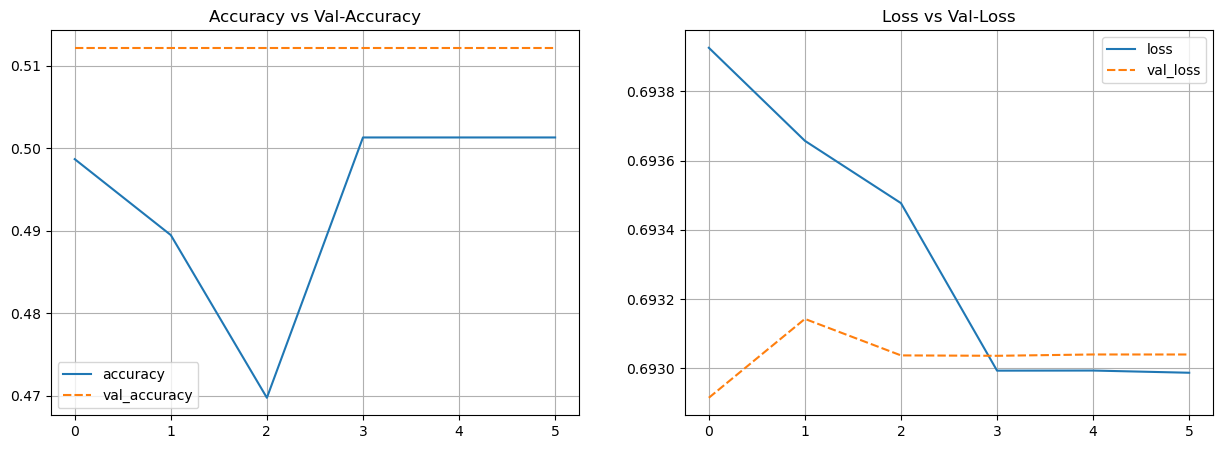

In [ ]:
#visualization of the accuracy and loss of the model
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

It can be seen that in the 3rd iteration, the accuracy and loss variable values are stagnant.

## NLP with Multiple Layers

This improvement model will use several layers such as bidirectional LSTM, dropout, hidden layer with relu activation and He uniform kernel initializer.

In [ ]:
#Model Definition

## Clear Session
seed = 100
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(100,return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(70, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed)))
model_lstm_2.add(Dense(50, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed)))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(Bidirectional(LSTM(10, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dense(1, activation='sigmoid'))

model_lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


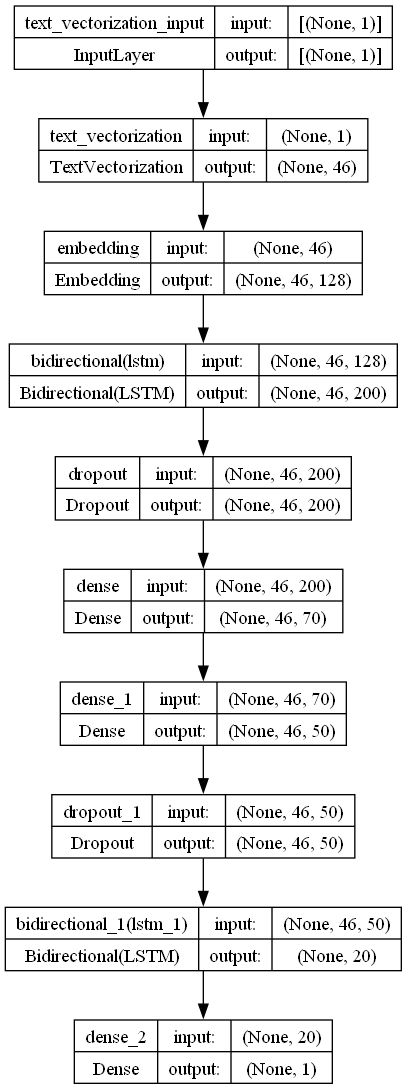

In [ ]:
#visualization of model 
tf.keras.utils.plot_model(model_lstm_2, show_shapes=True)


In this model there are several layers, namely

- 1 input layer
- Text Vectorization Process
- Embedding Process
- Bidirectional layer with 100 Neurons
- Dropout Process
- Hidden Layer with 70 Neurons
- Hidden Layer with 50 Neurons
- Dropout Process
- Bidirectional layer with 10 Neurons
- The output layer becomes 2 outputs

In [ ]:
model_lstm_2_hist = model_lstm_2.fit(X_train, y_train, epochs=20, batch_size=64,validation_data=(X_val, y_val),callbacks=callbacks)

Epoch 1/20
12/12 [==============================] - 7s 252ms/step - loss: 0.5279 - accuracy: 0.7855 - val_loss: 0.4693 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 2/20
12/12 [==============================] - 2s 150ms/step - loss: 0.1662 - accuracy: 0.9895 - val_loss: 0.4547 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/20
12/12 [==============================] - 2s 153ms/step - loss: 0.0685 - accuracy: 0.9895 - val_loss: 0.7574 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 4/20
12/12 [==============================] - 2s 153ms/step - loss: 0.0696 - accuracy: 0.9789 - val_loss: 0.6794 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 5/20
12/12 [==============================] - 2s 153ms/step - loss: 0.0317 - accuracy: 0.9961 - val_loss: 0.6851 - val_accuracy: 0.8049 - lr: 1.0000e-05
Epoch 6/20
12/12 [==============================] - 2s 153ms/step - loss: 0.0343 - accuracy: 0.9934 - val_loss: 0.6836 - val_accuracy: 0.8049 - lr: 1.0000e-05
Epoch 7/20
12/12 [==============================] - 2s 154ms/s

The model achieved an accuracy of 96.84% with a loss of 13.09% on the training data and an accuracy of 80.49% with a loss of 56.50% on the validation data. Observing the training log, the model appears to be overfitting as it demonstrates high accuracy on the training data but not as high on the validation data. With the use of callbacks, the training process halts at the 7th epoch/iteration as the model does not experience significant changes in training results.

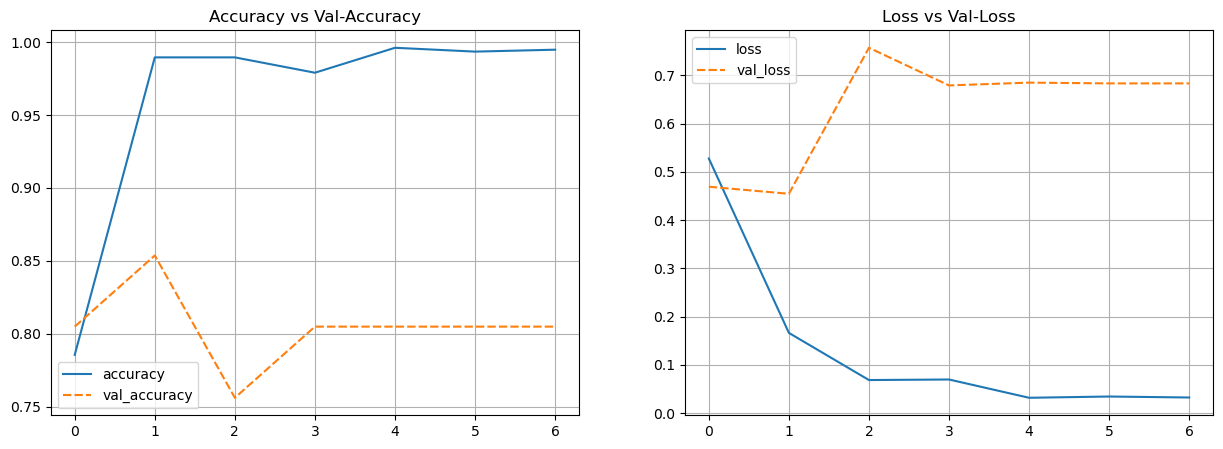

In [ ]:
#visualization of the accuracy and loss of the model
model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

can be seen in the 3rd iteration, the model performance is stagnant.

## Model Comparing and Evaluation

The model will make predictions on test data. The metrics that will be considered are __F1 score__ and __Accuracy__. Because the data used is balanced, F1 score and Accuracy can be used. The threshold used to determine the values 0 and 1 is 0.3 because in one of the experiments, this value was more appropriate for this case.

__Model with single layer__

In [ ]:
#Model training for single layer models
y_pred1 = model_lstm_1.predict(X_test)
prediction1 = np.where(y_pred1 > 0.3,1,0)

4/4 [==============================] - 0s 1ms/step


The model successfully predicts X_test data

In [ ]:
#classification report results on single layer model prediction results
print(classification_report(y_test, prediction1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.51      1.00      0.67        50

    accuracy                           0.51        99
   macro avg       0.25      0.50      0.34        99
weighted avg       0.26      0.51      0.34        99



c:\Users\D5att\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\D5att\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\D5att\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


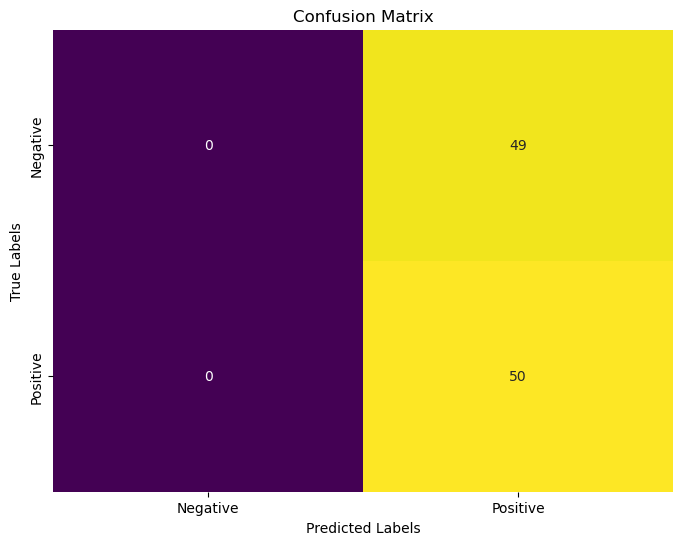

In [ ]:
cm = confusion_matrix(y_test, prediction1)

# Create a heatmap from the confusion matrix with the viridis color scheme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Based on the classification report, this model cannot predict negative values, which is represented by the recall, precision, and f1-score values for negative/0 predictions being equal to 0. The model can only predict positive values. This is also depicted in the heatmap visualization above, where the model can only predict positive values. The poor performance of the model is attributed to having only 1 layer, which prevents the model from learning patterns and generalizing well on the test data.

__Model with multiple layer__

In [ ]:
#Model training for multiple layer models
y_pred2 = model_lstm_2.predict(X_test)
prediction2 = np.where(y_pred2 > 0.3,1,0)

4/4 [==============================] - 1s 12ms/step


The model successfully predicts the X_test data

In [ ]:
#classification report results on multiple layer model prediction results
print(classification_report(y_test, prediction2))

              precision    recall  f1-score   support

           0       0.61      0.71      0.66        49
           1       0.67      0.56      0.61        50

    accuracy                           0.64        99
   macro avg       0.64      0.64      0.63        99
weighted avg       0.64      0.64      0.63        99



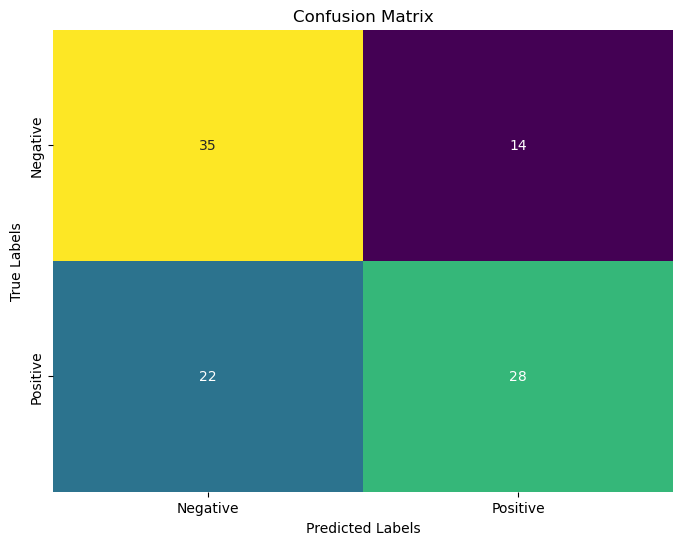

In [ ]:
cm = confusion_matrix(y_test, prediction2)

# Create a heatmap from the confusion matrix with the viridis color scheme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Based on the classification report values, this model is relatively underfit as its accuracy is 69% with an F1 score of 65% for predicting positive values. Upon examining the heatmap visualization, the model performs reasonably well in predicting negative sentiments, but it struggles to predict positive sentiments, with many false negatives. Multiple layer models tend to perform better than single layer models because they can learn patterns from tweets, enabling them to work more effectively.

With these two results, the better model is the second model, namely __model with multiple layers__.

## Model Saving

In [ ]:
#model saving
model_lstm_2.save('best_model.keras')
model_lstm_2.save('best_model.H5')

The model that is saved is a model with multiple layers. model saved successfully.

# Conclusion

Based on the training process of the single-layer and multiple-layer models, the multiple-layer model outperforms the single-layer model. This is influenced by several factors such as the model's ability to learn text patterns with weighted calculations at each layer, the impact of model parameters used, and the nature of the dataset. The multiple-layer model achieves an accuracy of 69% with an F1 score of 65% for predicting positive values. While the performance of this model is not exceptional, it is adequate for sentiment analysis.

To enhance model performance, several steps can be taken:
- Determining the appropriate model parameters (activation functions, kernel initializers, number of neurons).
- Selecting suitable hidden layers.
- Updating the dataset with a larger volume to facilitate better model learning.

In this dataset, the proportion of narratives for each candidate is evenly distributed. The proportion of negative and positive sentiments is also balanced. The most frequently mentioned tweets are related to the 2017 Jakarta gubernatorial election, candidates such as AHY, Anies-Sandi, and Ahok-Djarot.

Overall, this model can be utilized for sentiment analysis, but it would benefit from a larger dataset to improve its learning capabilities. Additionally, since the model learns from tweet datasets during the 2017 gubernatorial election, predicting beyond this topic could significantly impact its predictive accuracy.